In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from gensim.models import KeyedVectors
import gensim


In [4]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [6]:
train_data['text_clean'] = train_data['Text'].apply(lambda x: gensim.utils.simple_preprocess(x))
train_data.head()

,Sentence_id,Text,Verdict,text_clean
0,1,I think we've seen a deterioration of values.,-1,"[think, we, ve, seen, deterioration, of, values]"
1,2,I think for a while as a nation we condoned th...,-1,"[think, for, while, as, nation, we, condoned, ..."
2,3,"For a while, as I recall, it even seems to me ...",-1,"[for, while, as, recall, it, even, seems, to, ..."
3,4,"So we've seen a deterioration in values, and o...",-1,"[so, we, ve, seen, deterioration, in, values, ..."
4,5,"We got away, we got into this feeling that val...",-1,"[we, got, away, we, got, into, this, feeling, ..."


In [67]:
# Split data into features and target
X = train_data['text_clean']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [68]:
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=4,
                                   min_count=2)

In [69]:
w2v_model.wv.most_similar('trump')

[('presidential', 0.9903631210327148),
 ('roosevelt', 0.9895754456520081),
 ('lie', 0.9893749356269836),
 ('referring', 0.9892476797103882),
 ('recently', 0.988452136516571),
 ('assad', 0.9883522987365723),
 ('general', 0.9880269765853882),
 ('report', 0.9879698157310486),
 ('himself', 0.9878465533256531),
 ('charge', 0.9877020716667175)]

In [70]:
import torch
from torch.nn.utils.rnn import pad_sequence

words = set(w2v_model.wv.index_to_key)

# Convert sequences of word vectors to lists of tensors
X_train_vect = [torch.tensor([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train]
X_val_vect = [torch.tensor([w2v_model.wv[i] for i in ls if i in words]) for ls in X_val]

# Pad sequences to the same length
X_train_vect = pad_sequence(X_train_vect, batch_first=True, padding_value=0.0)
X_val_vect = pad_sequence(X_val_vect, batch_first=True, padding_value=0.0)

# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size(0) > 0:
        X_train_vect_avg.append(v.mean(dim=0))
    else:
        X_train_vect_avg.append(torch.zeros(100))

X_val_vect_avg = []
for v in X_val_vect:
    if v.size(0) > 0:
        X_val_vect_avg.append(v.mean(dim=0))
    else:
        X_val_vect_avg.append(torch.zeros(100))

# Convert lists to tensors
X_train_vect_avg = torch.stack(X_train_vect_avg)
X_val_vect_avg = torch.stack(X_val_vect_avg)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_str = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_train]
X_val_str = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_val]

# Assuming X_train and X_val are lists of text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val_str).toarray()

import numpy as np

# Assuming X_train_vect_avg and X_val_vect_avg are the word2vec embeddings
X_train_combined = np.hstack((X_train_vect_avg, X_train_tfidf))
X_val_combined = np.hstack((X_val_vect_avg, X_val_tfidf))

In [77]:
X_train_combined.shape, X_val_combined.shape

((18000, 5100), (4501, 5100))

## Neural network

In [78]:
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch.nn.functional as F
import torch

# Define your PyTorch model.
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, num_classes=3, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(hidden_dim1, num_classes)

    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [79]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import torch

# Hyperparameters
input_size = 100  # Size of word vectors
hidden_size = 50
num_epochs = 20
batch_size = 32
learning_rate = 0.005

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_vect_avg, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train + 1, dtype=torch.long)
X_test_tensor = torch.tensor(X_val_vect_avg, dtype=torch.float32)
y_test_tensor = torch.tensor(y_val.values + 1, dtype=torch.long)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size)
class_counts = y_train.value_counts()
class_weights = 1.0 / class_counts  # Inverse frequency of each class
weights = torch.tensor(class_weights.values, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)



# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

    f1 = f1_score(y_val, predicted - 1, average='macro')
    f1_per_class = f1_score(y_val, predicted - 1, average=None)

    print(f'Macro F1 Score: {f1:.4f}')
    print(f'F1 Score per class: {f1_per_class}')

/var/folders/_y/zh6_96751gv5msld9mzqk1bh0000gp/T/ipykernel_97348/1071348821.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_vect_avg, dtype=torch.float32)
/var/folders/_y/zh6_96751gv5msld9mzqk1bh0000gp/T/ipykernel_97348/1071348821.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_val_vect_avg, dtype=torch.float32)


Epoch [1/20], Loss: 0.7985, Accuracy: 55.36%
Epoch [2/20], Loss: 0.7705, Accuracy: 55.32%
Epoch [3/20], Loss: 0.7660, Accuracy: 55.79%
Epoch [4/20], Loss: 0.7579, Accuracy: 56.06%
Epoch [5/20], Loss: 0.7651, Accuracy: 55.32%
Epoch [6/20], Loss: 0.7611, Accuracy: 56.01%
Epoch [7/20], Loss: 0.7583, Accuracy: 55.84%
Epoch [8/20], Loss: 0.7585, Accuracy: 56.03%
Epoch [9/20], Loss: 0.7623, Accuracy: 55.91%
Epoch [10/20], Loss: 0.7540, Accuracy: 55.86%
Epoch [11/20], Loss: 0.7584, Accuracy: 55.90%
Epoch [12/20], Loss: 0.7582, Accuracy: 56.20%
Epoch [13/20], Loss: 0.7559, Accuracy: 56.09%
Epoch [14/20], Loss: 0.7615, Accuracy: 55.45%
Epoch [15/20], Loss: 0.7565, Accuracy: 56.03%
Epoch [16/20], Loss: 0.7573, Accuracy: 56.24%
Epoch [17/20], Loss: 0.7552, Accuracy: 55.62%
Epoch [18/20], Loss: 0.7565, Accuracy: 56.03%
Epoch [19/20], Loss: 0.7574, Accuracy: 55.76%
Epoch [20/20], Loss: 0.7566, Accuracy: 55.65%
Accuracy on the test set: 54.23%
Macro F1 Score: 0.3852
F1 Score per class: [0.63923911 0

Confusion matrix saved as 'confusion_matrix.png'


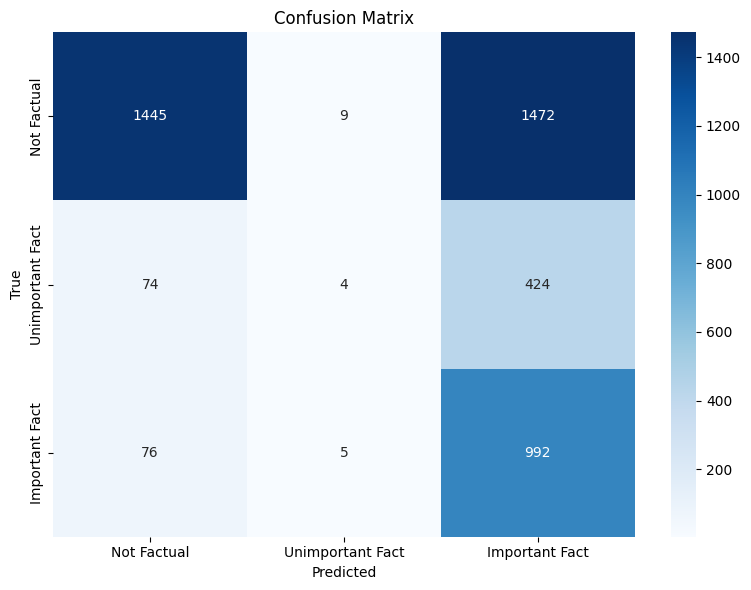

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, predicted - 1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

## Random forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_combined, y_train.values.ravel())

In [82]:

y_pred = rf_model.predict(X_val_combined)


validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.77      0.91      0.83      2926
           0       0.48      0.02      0.05       502
           1       0.54      0.52      0.53      1073

    accuracy                           0.71      4501
   macro avg       0.60      0.48      0.47      4501
weighted avg       0.68      0.71      0.67      4501

Accuracy: 0.7141
Macro F1 Score: 0.4682
F1 Score per class:
  Not Factual: 0.8296
  Unimportant Fact: 0.0455
  Important Fact: 0.5294


Confusion matrix saved as 'confusion_matrix.png'


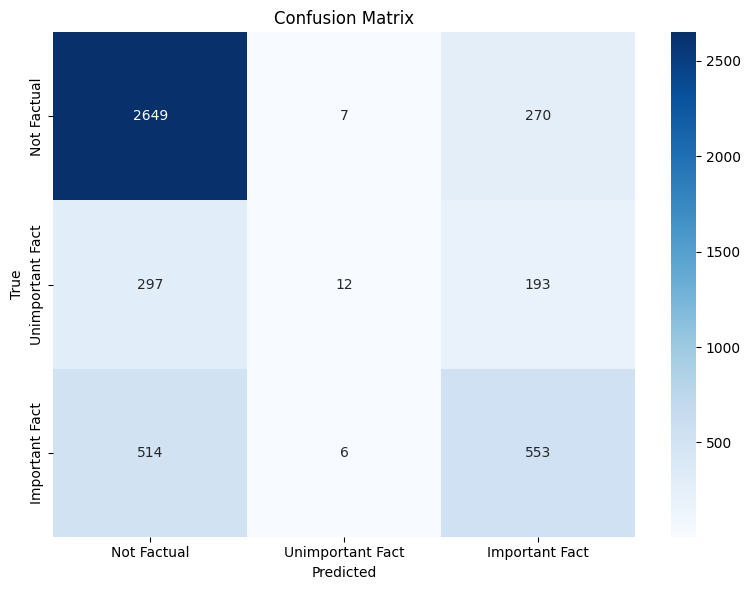

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

## Logistic regression

In [84]:
from sklearn.linear_model import LogisticRegression


y_train_mapped = y_train.values + 1
y_val_mapped = y_val.values + 1

logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_combined, y_train_mapped)

LogisticRegression(class_weight='balanced', max_iter=1000)

Accuracy on the validation set: 70.45%
Macro F1 Score: 0.6154
F1 Score per class: [0.80841387 0.40031771 0.63746959]
Confusion matrix saved as 'confusion_matrix.png'


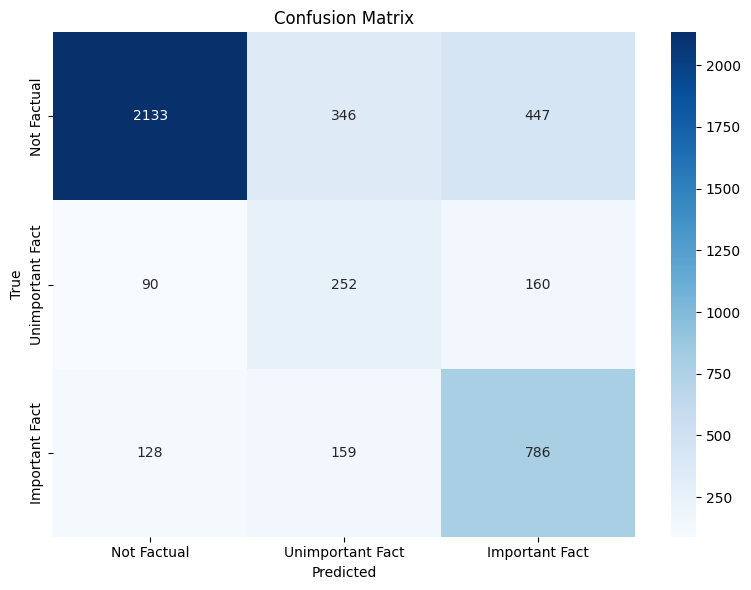

In [92]:
y_val_pred = logreg.predict(X_val_combined)

# Evaluate the model
accuracy = accuracy_score(y_val_mapped, y_val_pred)
f1 = f1_score(y_val_mapped, y_val_pred, average='macro')
f1_per_class = f1_score(y_val_mapped, y_val_pred, average=None)

print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')
print(f'Macro F1 Score: {f1:.4f}')
print(f'F1 Score per class: {f1_per_class}')

# Create and plot confusion matrix
cm = confusion_matrix(y_val_mapped, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [87]:
# Save the model
joblib.dump(logreg, 'logreg.pkl')
print("Model saved as 'logreg.pkl'")
model = joblib.load('logreg.pkl')

Model saved as 'logreg.pkl'


In [90]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    X_test = test_data['Text'].tolist()  # Assuming the text column is named 'text'

    # Preprocess the test data
    X_test_str = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_test]
    X_test_tfidf = tfidf_vectorizer.transform(X_test_str).toarray()

    # Convert sequences of word vectors to lists of tensors
    words = set(w2v_model.wv.index_to_key)
    X_test_vect = []
    for doc in X_test_str:
        word_vectors = [w2v_model.wv[i] for i in doc.split() if i in words]
        if len(word_vectors) > 0:
            X_test_vect.append(np.mean(word_vectors, axis=0))
        else:
            X_test_vect.append(np.zeros(100))  # Assuming word2vec vectors are of size 100

    # Combine TF-IDF features with word2vec embeddings
    X_test_vect = np.array(X_test_vect)
    X_test_combined = np.hstack((X_test_vect, X_test_tfidf))

    
    # Make predictions
    predictions = model.predict(X_test_combined)
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions - 1
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('logreg.pkl', 'data/test.csv', 'data/logreg_predictions.csv')


Making predictions on test data...
Predictions saved to data/logreg_predictions.csv
